# **COMP6125 Development Notebook**
Group Members:

1.   Akeem Murray
2.   Clive Simpson
3.   Orane Thompson


# **Overview of the Dataset**

This intended use of this dataset is to train a model that is able to confidently classify Jamaican dollar (JMD) \$500 and \$1,000 bank notes.

The dataset was created by mainly taken pictures of the two bank notes with smartphone cameras, in different lighting, positions and physical conditions. Some images were retrieved from Google Image search and Shutterstock (downloaded with a paid license). Additionally, some 30 images were crowd sourced via Google Forms.

There are 61 images in total in the dataset. There are a total of 859 images of JMD \$500 bank notes, and there are a total of 1050 images of JMD \$1,000 bank notes.

There are two subdirectories, one per class, with the directory name denoting the class name:

```
data/
  500_jmd_bank_notes/
  1000_jmd_bank_notes/
```

All images are copyright of their respective owners.




In [ ]:
import os
%load_ext autoreload

## Setup environment specific requirements and set paths. This is to accommodate
## running from Google Colab or from a local directory

if( os.path.isdir("/content") ):
  # Setup Specific to Google Colab Environment
  print("Running from Google Colab Environment")
                  
  !pip install requests
  !pip install requests-oauthlib
  !pip install ratelimit
  
  from google.colab import drive
  drive.mount('/content/drive')
      
  %cd "/content/drive/My Drive/COMP6125 Project"

  # Get current working directory
  cwd = os.getcwd()

  # Extract the dataset - uncomment below only if the dataset is in an .zip archive format
  # !unzip -uq "/content/drive/My Drive/COMP6125 Project/data.zip" -d "/content/drive/My Drive/COMP6125 Project/"
  
else:
  # Setup Specific to Local Jupyter Environment
  print('Running from Local Jupyter Environment')
 
  # Get current working directory
  cwd = os.getcwd()

Running from Google Colab Environment
  Created wheel for ratelimit: filename=ratelimit-2.2.1-cp36-none-any.whl size=5893 sha256=cb260fbabc6fd6394c29f5417bf457cd7dfa8596e58a24481ee096e7e83e23d9
  Stored in directory: /root/.cache/pip/wheels/05/d9/82/3c6044cf1a54aab9151612458446d9b17a38416869e1b1d9b8
Successfully built ratelimit
Mounted at /content/drive
/content/drive/My Drive/COMP6125 Project


In [ ]:
# Import TensorFlow and other required libraries

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# Set path to data folder

import pathlib

data_dir = cwd + '/data/'
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/drive/My Drive/COMP6125 Project/data


In [ ]:
# Count the total number of images in the dataset

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1687


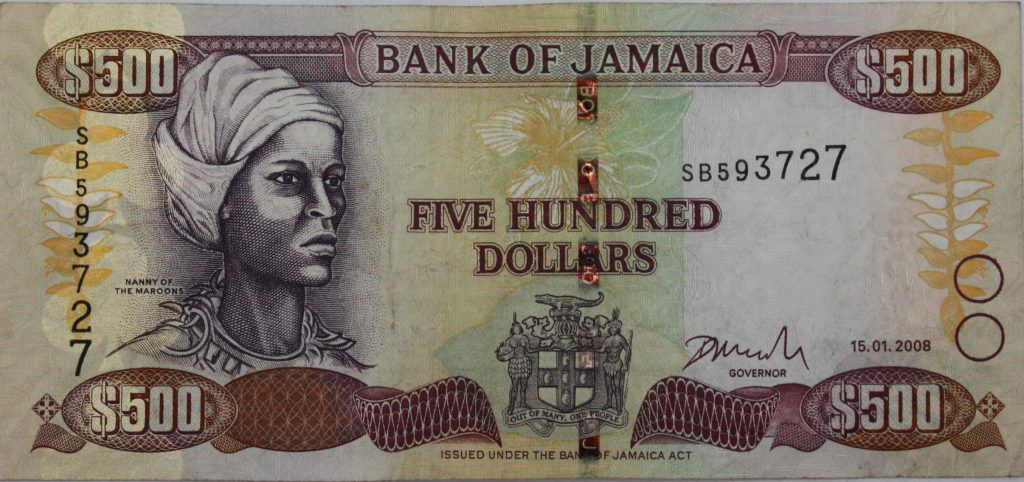

In [ ]:
# Get a sample image

jmd_500 = list(data_dir.glob('500_jmd_bank_notes/*'))
PIL.Image.open(str(jmd_500[3]))

In [ ]:
# Dataset parameters
batch_size = 20
img_height = 150
img_width = 150

# Create the training dataset. 30% of all images in the dataset will be used for training the model.
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.3,
  subset = "training",
  seed = 713,
  shuffle = True,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = 'binary'
)

Found 1687 files belonging to 2 classes.
Using 1181 files for training.


In [ ]:
# Create the validation dataset. The remaining 70% of images will be used for validating the model.
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split = 0.3,
  subset = "validation",
  seed = 713,
  shuffle = True,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  label_mode = 'binary'
)

Found 1687 files belonging to 2 classes.
Using 506 files for validation.


In [ ]:
# Set the class names, which defaults to the folder names in which the images are stored
class_names = training_dataset.class_names
print(class_names)

['1000_jmd_bank_notes', '500_jmd_bank_notes']


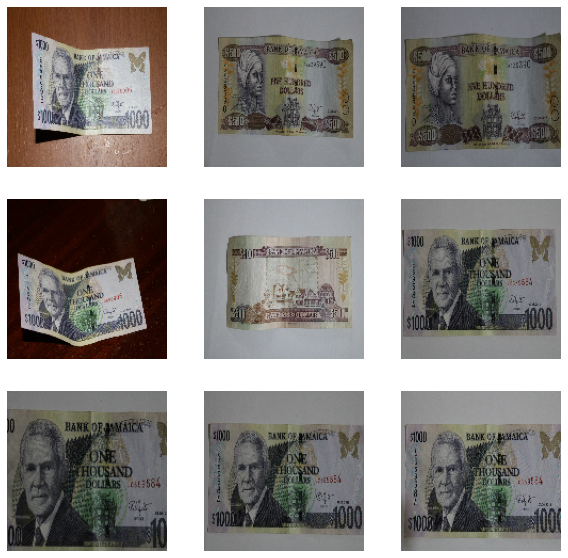

In [ ]:
# Visual the dataset, fetch images from both classes
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# AUTOTUNE is used to configure the dataset for performance

# dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# Data augmentation
# As the dataset is limited, we will need to augment the images via a number of random transformations.
# This is done so that at training time, the model will never see the exact same picture twice during training. 
# This helps prevent overfitting and helps the model generalize better.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical', input_shape = (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

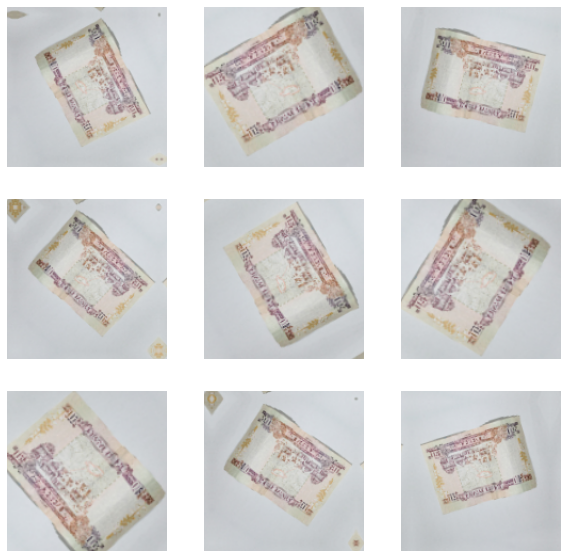

In [ ]:
# Display the results of the data augmentation for a single image

plt.figure(figsize = (10, 10))
for images, _ in validation_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
# Build the model
# Apply layers.Dropout in the creation of the model, in order to reduce overfitting

num_classes = 2

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer = RMSprop(lr=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# View summary of the model
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_31 (Sequential)   (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_22 (Rescaling)     (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 37, 37, 64)      

In [ ]:
# Train the model, after Data Augmentation and Dropout has been applied

epochs = 15
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = epochs
)

Epoch 1/15
60/60 [==============================] - 66s 775ms/step - loss: 0.6869 - accuracy: 0.5538 - val_loss: 0.6357 - val_accuracy: 0.5672
Epoch 2/15
60/60 [==============================] - 38s 632ms/step - loss: 0.6268 - accuracy: 0.6972 - val_loss: 0.8103 - val_accuracy: 0.5158
Epoch 3/15
60/60 [==============================] - 38s 639ms/step - loss: 0.5104 - accuracy: 0.7897 - val_loss: 0.5004 - val_accuracy: 0.7352
Epoch 4/15
60/60 [==============================] - 38s 631ms/step - loss: 0.4044 - accuracy: 0.8467 - val_loss: 0.5296 - val_accuracy: 0.7213
Epoch 5/15
60/60 [==============================] - 38s 631ms/step - loss: 0.3598 - accuracy: 0.8672 - val_loss: 0.2707 - val_accuracy: 0.8933
Epoch 6/15
60/60 [==============================] - 38s 630ms/step - loss: 0.2858 - accuracy: 0.9024 - val_loss: 0.2212 - val_accuracy: 0.9091
Epoch 7/15
60/60 [==============================] - 39s 643ms/step - loss: 0.2322 - accuracy: 0.9167 - val_loss: 0.3517 - val_accuracy: 0.8735

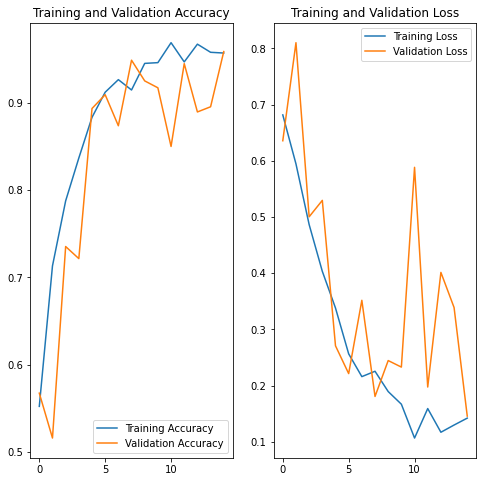

In [ ]:
# Evaluate the results of the model training

# Retrieve a list of accuracy results on training and validation data
# Sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# Sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs_range = range(epochs)

# Plot training and validation accuracy per epoch
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Save the model to disk
# The model will be imported into the deployment notebook

saved_model = cwd + '/bank-note-recognition-model.h5'
model.save(saved_model)

In [ ]:
# For testing only, use the model to predict on new data
# Actual implementation in Deployment Notebook

image_url = "http://www.ra2d.com/images/worldsmoney/Jamaican-Dollar-JMD-Definition/jmd-1000-jamaican-dollars-2.jpg"
image_path = tf.keras.utils.get_file('predict_img_test_8', origin=image_url) #increment the number by one for each run

img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)

for i, predicted in enumerate(predictions):
  if predicted[0] > 0.75:
      print(
          "This image is a JMD $500 bank note. Prob: {}"
          .format(predicted[0])
      )
  elif predicted[0] <= 0.75 and predicted[0] > 0.000000005:
        print(
            "This image is a JMD $1,000 bank note. Prob: {}"
          .format(predicted[0])
        )
  else: print("Bank note not recognized. Prob: {}"
          .format(predicted[0])
      )

This image is a JMD $1,000 bank note. Prob: 0.014851480722427368
